In [4]:
import Trigger_Parallel_Working as tp

In [ ]:
tp.run(path) #223s

In [1]:
import logging
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from ananke.models.collection import Collection
from ananke.configurations.collection import HDF5StorageConfiguration
from joblib import Parallel, delayed
import os


def save_dataframe_to_hdf(df: pd.DataFrame, file_path: str):
    """
    Save a DataFrame to an HDF5 file at the specified path.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        file_path (str): The path (including filename) where the DataFrame should be saved.
    """
    # Check and convert data types if necessary
    for col in df.select_dtypes(include=['object']).columns:
        # Convert lists/arrays to strings or other appropriate type if necessary
        df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)
    
    # Create the directory if it doesn't exist
    directory = os.path.dirname(file_path)
    os.makedirs(directory, exist_ok=True)
    
    # Save the DataFrame to HDF5 with handling for large integers
    try:
        df.to_hdf(file_path, key='df', mode='w', min_itemsize={'your_column_name': 64})  # Adjust as needed
        print(f"DataFrame successfully saved to {file_path}")
    except OverflowError as e:
        print(f"OverflowError: {e}. Consider checking the data types and values in the DataFrame.")




# Set logging level to INFO
logging.getLogger().setLevel(logging.INFO)

def initialize_collection(path: str):
    """Initialize and return the Collection object."""
    config = HDF5StorageConfiguration(data_path=path, read_only=False)
    collection = Collection(config)
    return collection

def load_data(collection, 
              trigger_interval: int = 10, 
              ignore_records: bool = False):
    """Load hit and source data from the collection."""
    collection.open()
    hits = collection.storage.get_hits()  # Fetch hits from the collection
    collection.close()

    upper_limit = hits.get_statistics().max
    lower_limit = hits.get_statistics().min
    timer = np.arange(lower_limit, upper_limit + trigger_interval, trigger_interval)
    intervals = (timer[1:] + timer[:-1]) / 2

    records = [1] if ignore_records else hits.df['record_id'].drop_duplicates()

    return hits, records, timer, intervals

# Custom aggregation functions
def concatenate_arrays(arrays):
    """Concatenate a list of numpy arrays into a single numpy array."""
    carrays=np.concatenate(arrays.values)
    carrays.sort
    return carrays

def sum_arrays(arrays):
    """Sum a list of numpy arrays element-wise."""
    return np.sum(arrays.values, axis=0)

In [ ]:
def save_dataframe_to_hdf(df: pd.DataFrame, file_path: str):
    """
    Save a DataFrame to an HDF5 file at the specified path.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        file_path (str): The path (including filename) where the DataFrame should be saved.
    """
    # Check and convert data types if necessary
    for col in df.select_dtypes(include=['object']).columns:
        # Convert lists/arrays to strings or other appropriate type if necessary
        df[col] = df[col].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)
    
    # Create the directory if it doesn't exist
    directory = os.path.dirname(file_path)
    os.makedirs(directory, exist_ok=True)
    
    # Save the DataFrame to HDF5 with handling for large integers
    try:
        df.to_hdf(file_path, key='df', mode='w', min_itemsize={'your_column_name': 64})  # Adjust as needed
        print(f"DataFrame successfully saved to {file_path}")
    except OverflowError as e:
        print(f"OverflowError: {e}. Consider checking the data types and values in the DataFrame.")

# Example usage
# Assuming plot_data is defined and populated elsewhere in your code

#save_dataframe_to_hdf(plot_data,'data/LargeSMerge/TriggerData/plot_data/1000s.h5')
#save_dataframe_to_hdf(x,'data/LargeSMerge/TriggerData/grouped_data/1000s.h5')

In [ ]:
import logging
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from ananke.models.collection import Collection
from ananke.configurations.collection import HDF5StorageConfiguration


# Set logging level to INFO
logging.getLogger().setLevel(logging.INFO)

def initialize_collection(data_path: str):
    """Initialize and return the Collection object."""
    config = HDF5StorageConfiguration(data_path=data_path, read_only=False)
    collection = Collection(config)
    return collection

def load_data(collection, trigger_interval: int = 10, ignore_records: bool = False):
    """Load hit and source data from the collection."""
    collection.open()
    hits_data = collection.storage.get_hits()  # Fetch hits from the collection
    collection.close()

    upper_limit = hits_data.get_statistics().max
    lower_limit = hits_data.get_statistics().min
    timer_bins = np.arange(lower_limit, upper_limit + trigger_interval, trigger_interval)
    time_intervals = (timer_bins[1:] + timer_bins[:-1]) / 2

    unique_records = [1] if ignore_records else hits_data.df['record_id'].drop_duplicates()

    return hits_data, unique_records, timer_bins, time_intervals

def concatenate_arrays(array_list):
    """Concatenate a list of numpy arrays into a single numpy array."""
    concatenated_array = np.concatenate(array_list.values)
    concatenated_array.sort()
    return concatenated_array

def sum_arrays(array_list):
    """Sum a list of numpy arrays element-wise."""
    return np.sum(array_list.values, axis=0)

def process_hits(hits_data, timer_bins):
    """Process hits data and return aggregated results."""
    # Grouping by multiple fields
    grouped_data = hits_data.df.groupby(['record_id', 'string_id', 'module_id', 'pmt_id'])['time'] \
            .apply(lambda times: np.sort(np.array(times))) \
            .reset_index()

    # Initialize arrays for counting and activation
    count_array = np.zeros((grouped_data.shape[0], len(timer_bins) - 1)).astype(int)
    pmt_activation_array = np.zeros((grouped_data.shape[0], len(timer_bins) - 1)).astype(int)

    # Timing the histogram creation
    start_time = time.time()
    for i in range(grouped_data.shape[0]):
        count_array[i] = np.histogram(grouped_data['time'][i], bins=timer_bins)[0].astype(int)
        pmt_activation_array[i] = np.where(count_array[i] > 0, 1, 0)
    logging.info(f'Histogram creation time: {time.time() - start_time:.2f}s')

    # Assign counts and activations to the DataFrame
    grouped_data['counts'] = [count_array[i] for i in range(count_array.shape[0])]
    grouped_data['pmt_activation'] = [pmt_activation_array[i] for i in range(pmt_activation_array.shape[0])]

    # Perform the grouping and aggregation without 'pmt_id'
    aggregated_data = (
        grouped_data.groupby(['record_id', 'string_id', 'module_id'])
        .agg({
            'time': concatenate_arrays,  # Concatenate time arrays
            'counts': sum_arrays,         # Sum the counts arrays
            'pmt_activation': sum_arrays   # Sum the pmt_activation arrays
        })
        .reset_index()
    )

    return aggregated_data

def create_results_dataframe(aggregated_data):
    """Create results DataFrame with necessary calculations."""
    results_dataframe = aggregated_data[['record_id', 'string_id', 'module_id']].copy()
    for threshold in range(16):
        results_dataframe[f'Mod Count CL: {threshold}'] = aggregated_data['pmt_activation'].apply(lambda x: np.where(x > threshold, 1, 0))
        results_dataframe[f'Mod Hit Count CL: {threshold}'] = results_dataframe[f'Mod Count CL: {threshold}'] * aggregated_data['counts']
        results_dataframe[f'TS CL: {threshold}'] = aggregated_data[results_dataframe[f'Mod Count CL: {threshold}'].apply(np.sum) > 0]['time']
        results_dataframe[f'TS CL: {threshold}'] = results_dataframe[f'TS CL: {threshold}'].apply(lambda times: np.where(np.isnan(times), np.array([0]), times))

    return results_dataframe

def aggregate_for_plotting(results_dataframe):
    """Prepare the data for plotting by aggregating necessary columns."""
    aggregation_dict_a = {col: sum_arrays for col in results_dataframe.columns if col.startswith('Mod') or col.startswith('TS')}
    aggregation_dict_b = {col: concatenate_arrays for col in results_dataframe.columns if col.startswith('TS')}
    combined_aggregation_dict = {**aggregation_dict_a, **aggregation_dict_b}
    
    plot_data = (
        results_dataframe.groupby(['record_id'])
        .agg(combined_aggregation_dict)
        .reset_index()
    )

    return plot_data

def plot_results(plot_data, time_intervals, confidence_level):
    """Plot the results for each record."""
    for record_id in plot_data['record_id']:
        logging.info(f'Plotting results for record: {record_id}')
        record_data = plot_data[plot_data['record_id'] == record_id][[f'Mod Count CL: {confidence_level}', f'Mod Hit Count CL: {confidence_level}', f'TS CL: {confidence_level}']]
        
        plt.figure().set_figwidth(15)
        plt.suptitle(f'Record: {record_id}')

        plt.subplot(1, 3, 1)
        plt.scatter(time_intervals, record_data[f'Mod Count CL: {confidence_level}'].iloc[0])
        plt.title('Modules Triggered per Interval')
        plt.ylabel('Number of Modules')
        plt.xlabel('Intervals')

        plt.subplot(1, 3, 2)
        plt.scatter(time_intervals, np.log10(record_data[f'Mod Hit Count CL: {confidence_level}'].iloc[0] + 1))
        plt.title('Total Hits of Triggered Modules per Interval')
        plt.ylabel('log(Total Hits + 1)')
        plt.xlabel('Intervals')

        plt.subplot(1, 3, 3)
        time_stamps = record_data[f'TS CL: {confidence_level}'].iloc[0][record_data[f'TS CL: {confidence_level}'].iloc[0] > 0]
        time_stamps.sort()
        
        if time_stamps.size <= 1:
            plt.axhline(y=0)
            plt.show()
            continue
        
        histogram_bins = np.linspace(min(time_stamps), max(time_stamps), num=100)
        hit_counts, _ = np.histogram(time_stamps, histogram_bins)
        bin_centers = (histogram_bins[:-1] + histogram_bins[1:]) / 2
        plt.plot(bin_centers, hit_counts)
        plt.xlabel('Time in ns')
        plt.ylabel('log(Hit Count)')
        plt.yscale('log')
        plt.title('Hits in Real Time')

        plt.tight_layout()
        plt.show()

def main(data_path: str, trigger_interval: int = 10, ignore_records: bool = False, confidence_level: int = 10):
    """Main function to execute the data loading, processing, and plotting."""
    collection = initialize_collection(data_path)
    hits_data, unique_records, timer_bins, time_intervals = load_data(collection, trigger_interval, ignore_records)
    aggregated_data = process_hits(hits_data, timer_bins)
    results_dataframe = create_results_dataframe(aggregated_data)
    plot_data = aggregate_for_plotting(results_dataframe)
    plot_results(plot_data, time_intervals, confidence_level)



In [2]:
from importlib import reload
import Trigger_Improve
reload(Trigger_Improve)
import Trigger_Improve as ti

In [8]:
path='data/LargeCMerge/0.h5'

INFO:root:Running main
INFO:root:Initializing Collections
INFO:root:Loading Data
INFO:root:Started Processing Hits
INFO:root:Histogram creation time: 2.06s
INFO:root:Finished Processing Hits
INFO:root:Creating Results df
INFO:root:Created Results df
INFO:root:Generating plotable results
INFO:root:Generated
INFO:root:Plotting results for record: 0


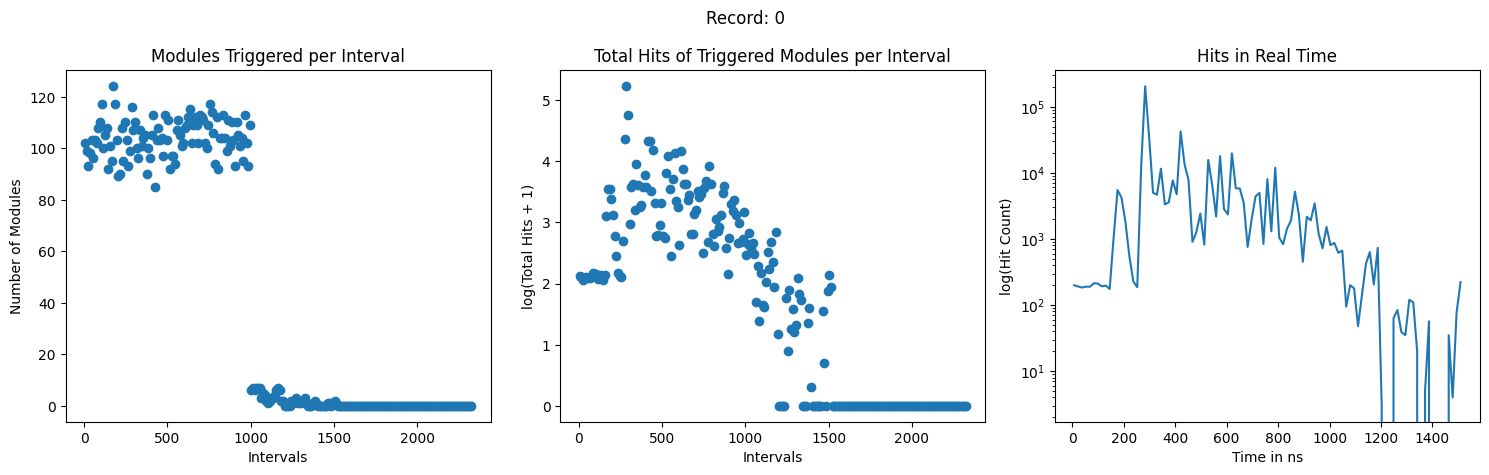

INFO:root:Plotting results for record: 3


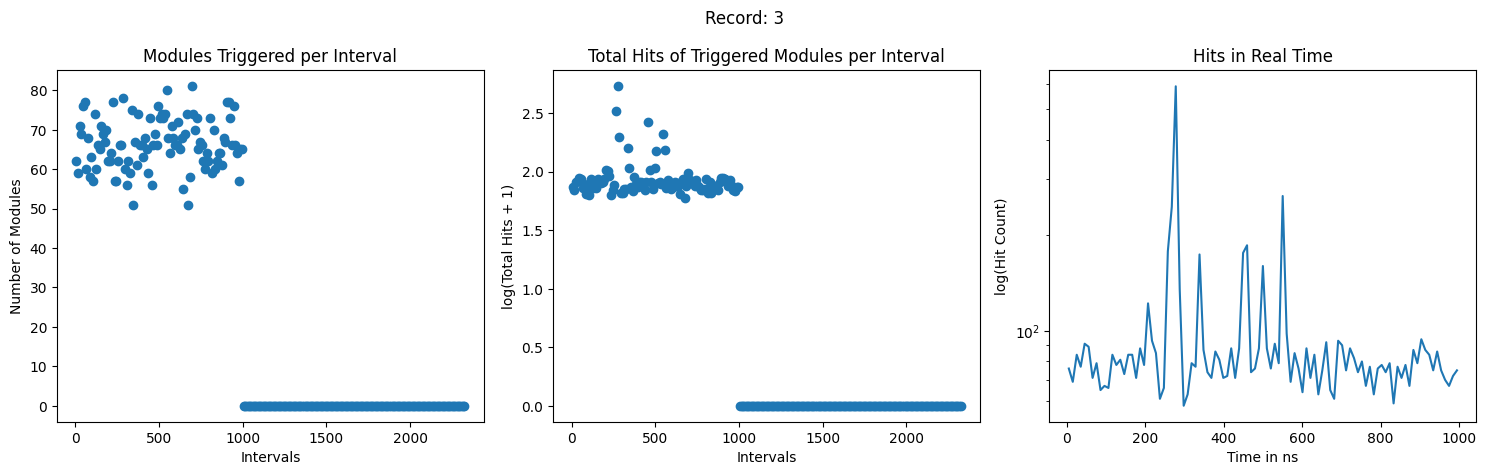

INFO:root:Plotting results for record: 4


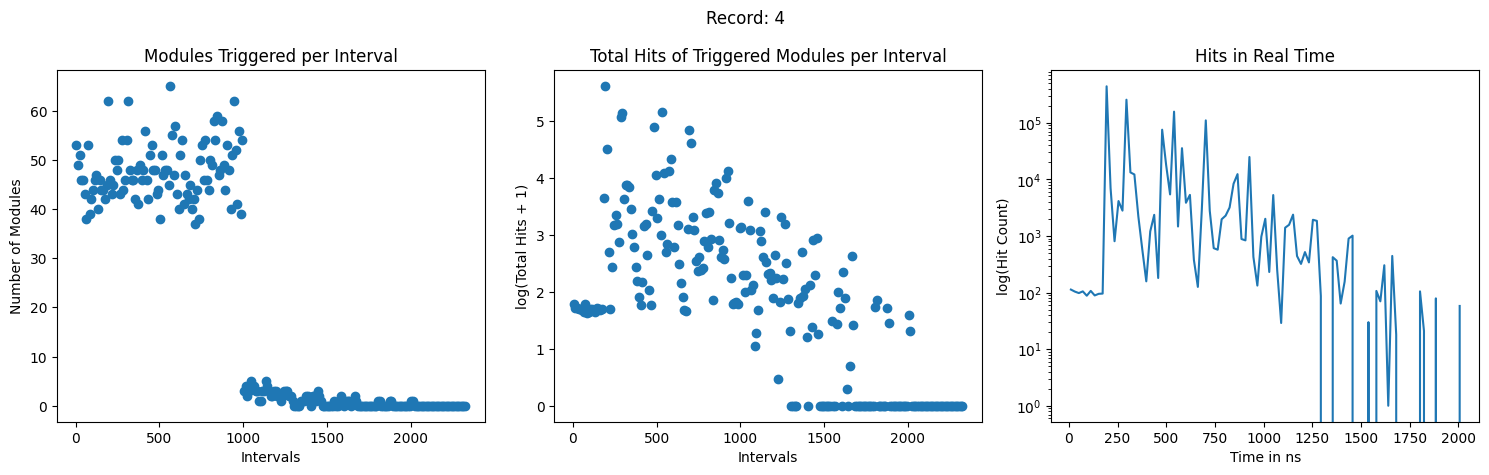

INFO:root:Plotting results for record: 6


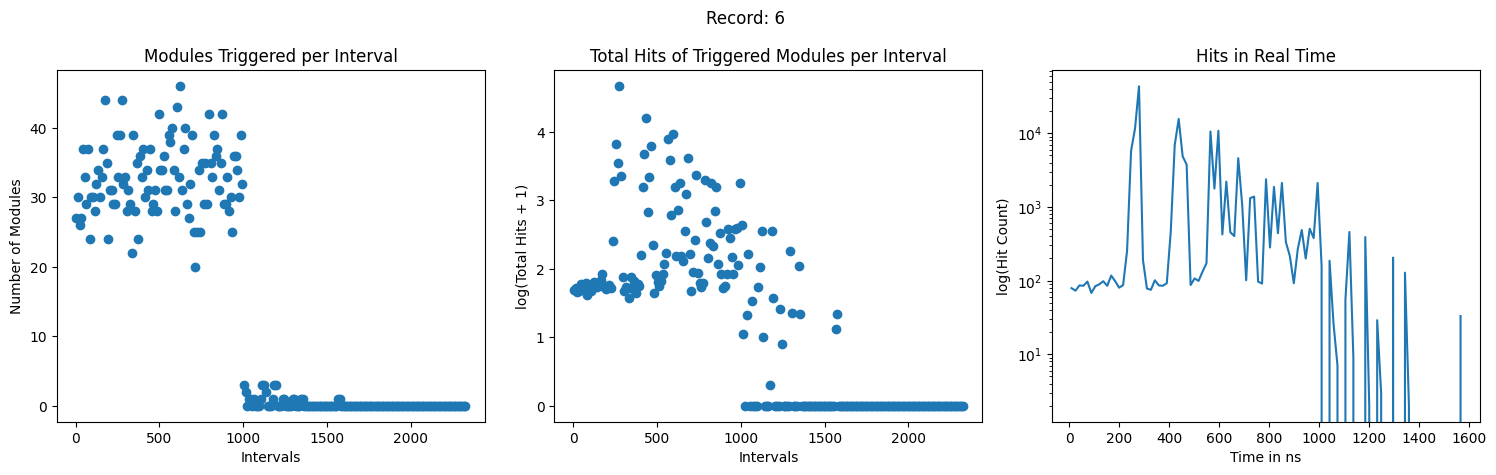

INFO:root:Plotting results for record: 8


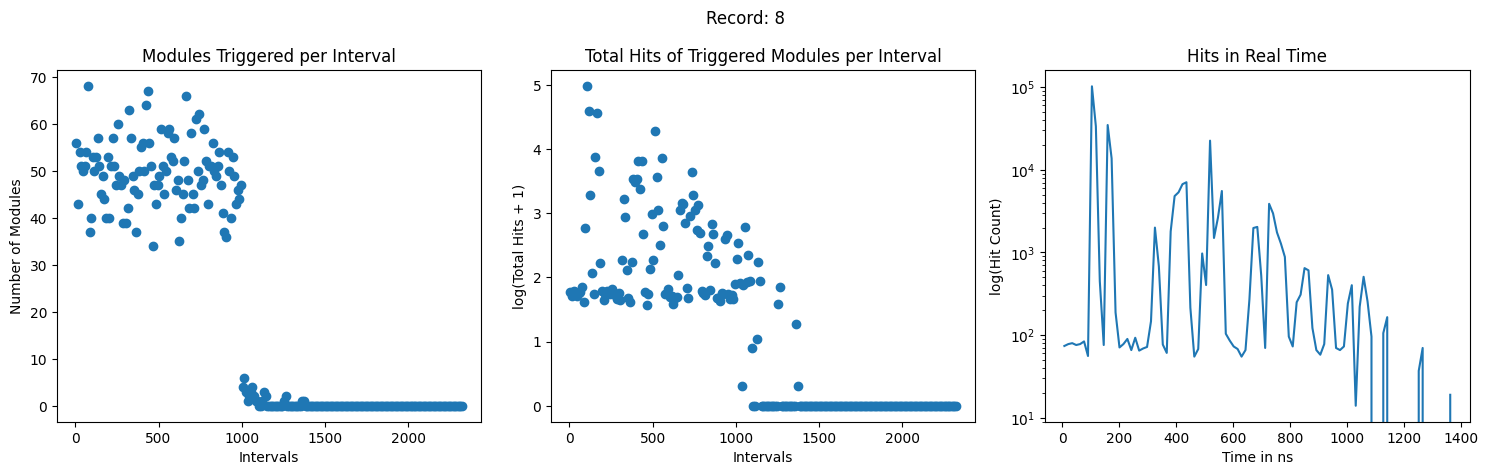

INFO:root:Plotting results for record: 9


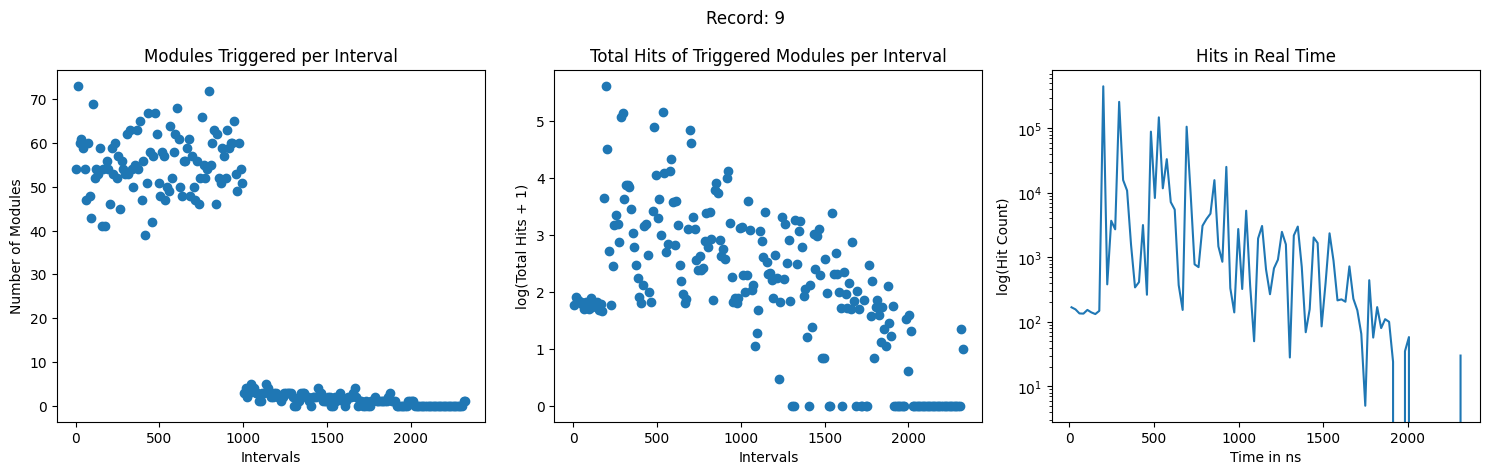

INFO:root:Plotting results for record: 12


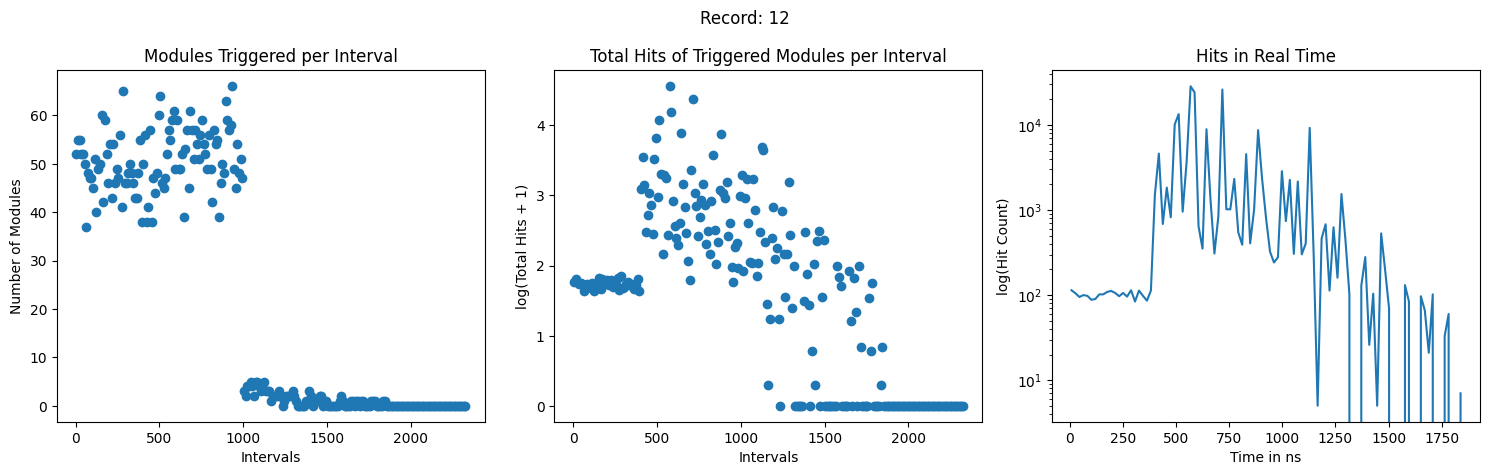

INFO:root:Plotting results for record: 16


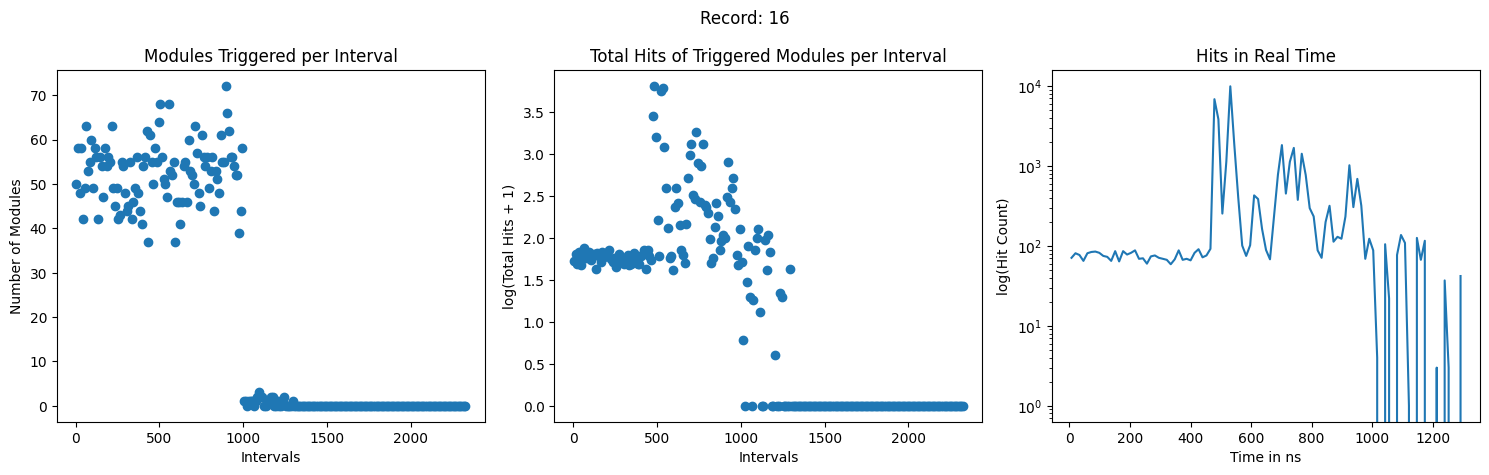

INFO:root:Plotting results for record: 17


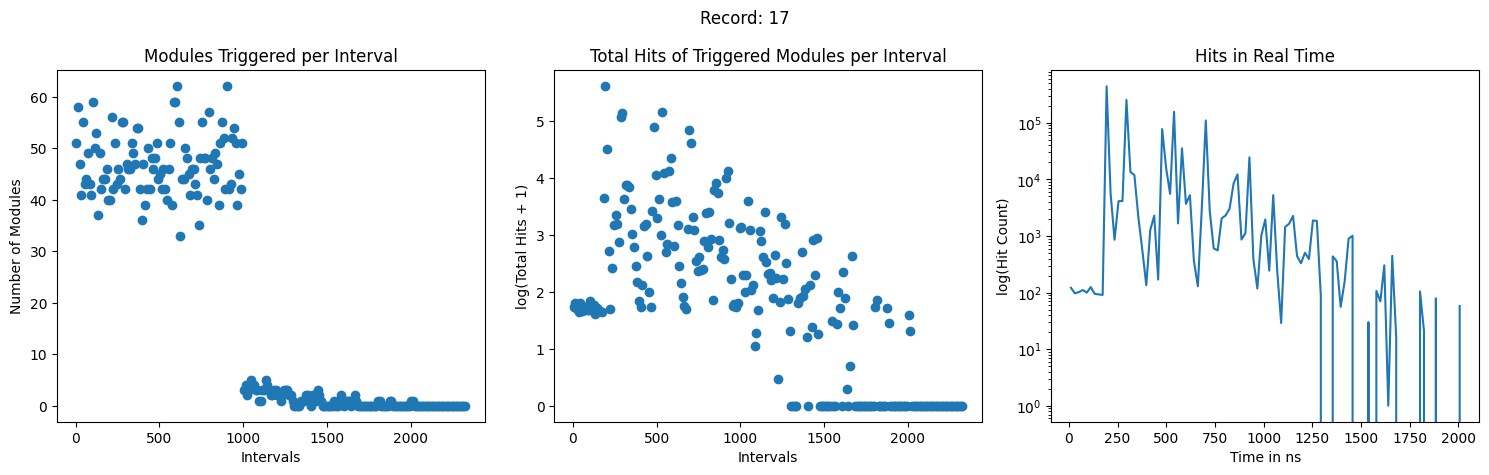

INFO:root:Plotting results for record: 18


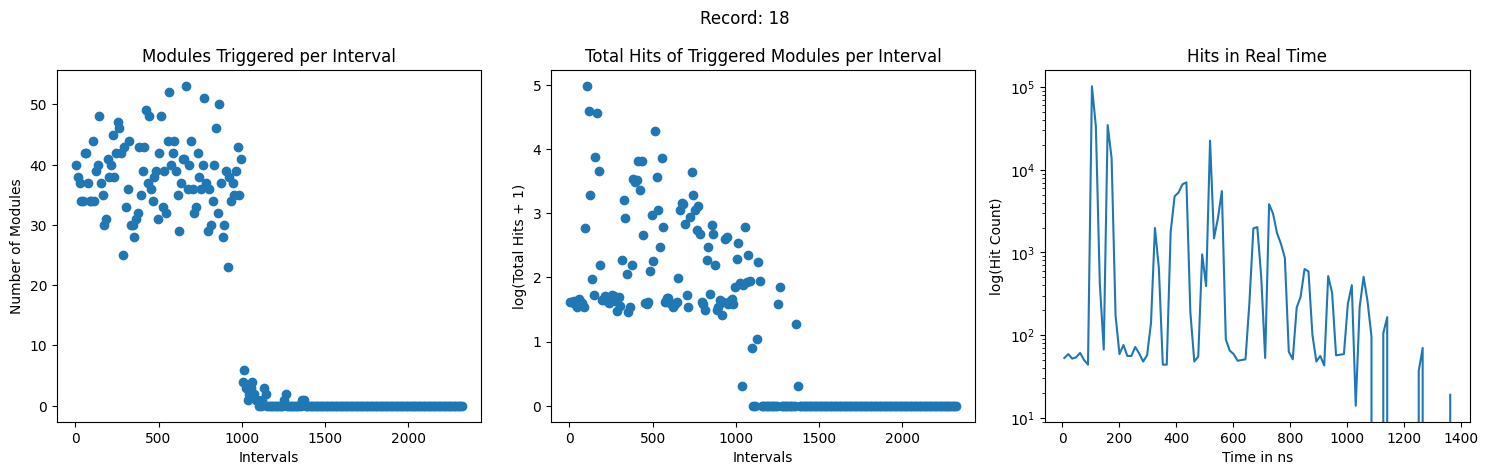

INFO:root:Plotting results for record: 19


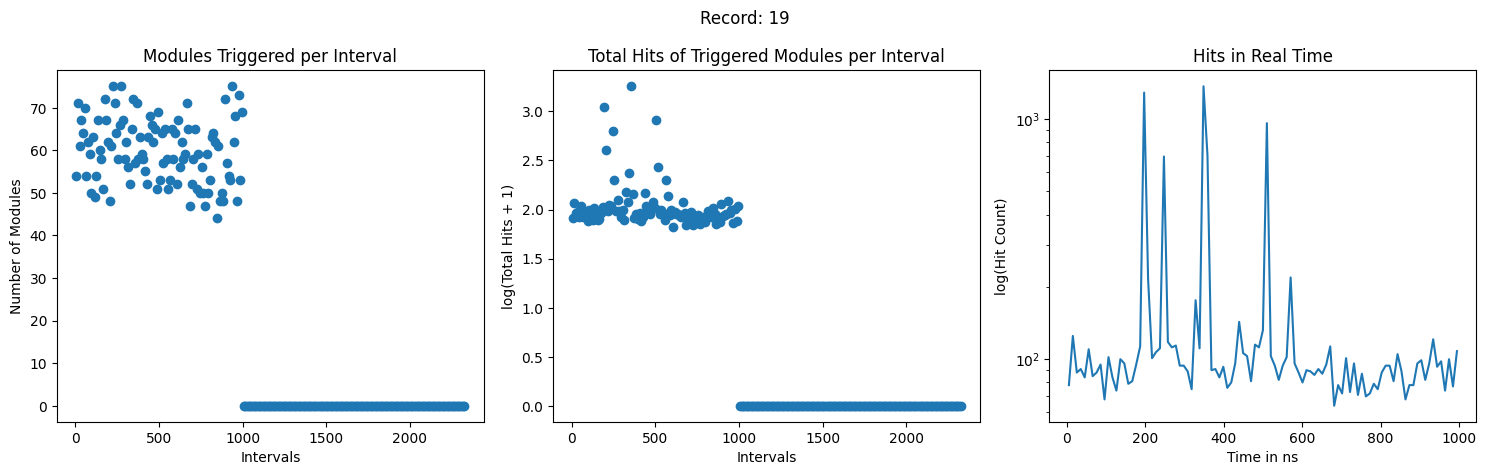

INFO:root:Plotting results for record: 21


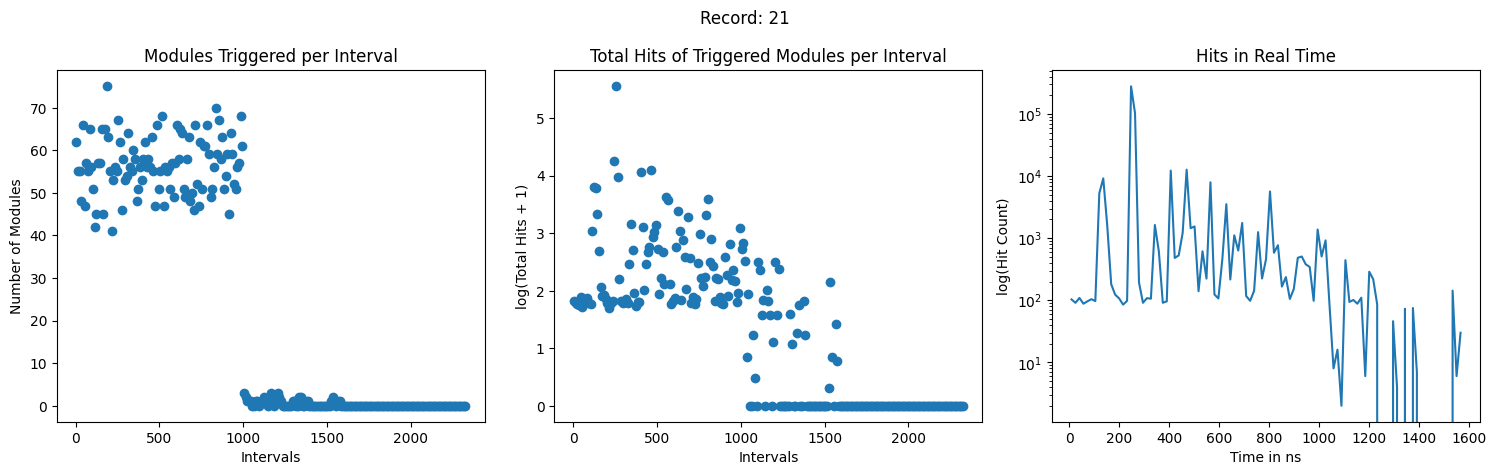

INFO:root:Plotting results for record: 22


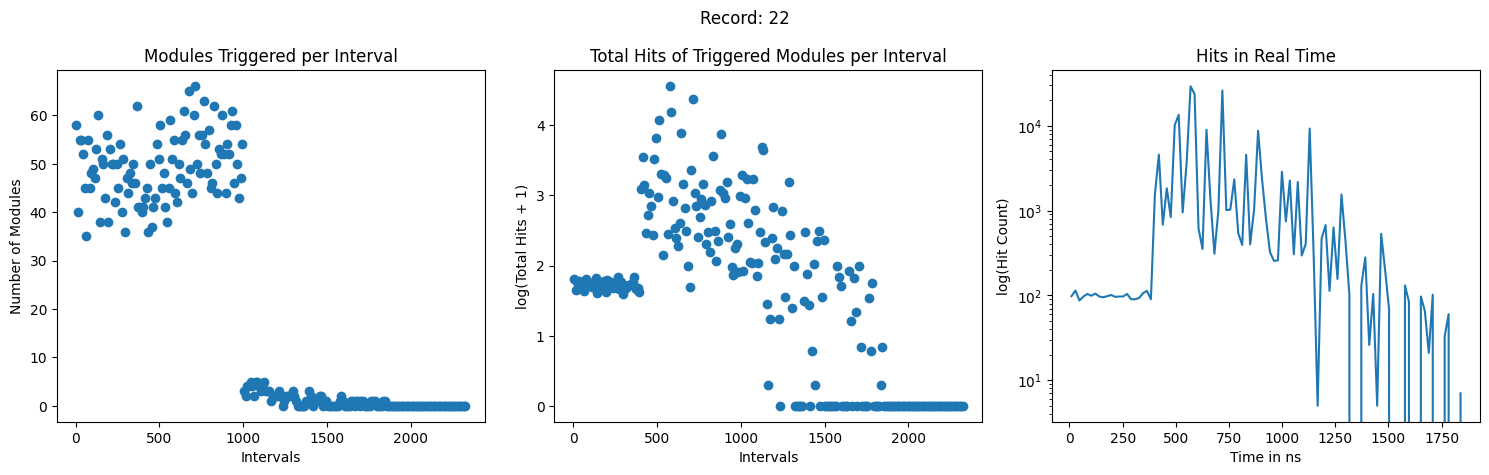

INFO:root:Plotting results for record: 23


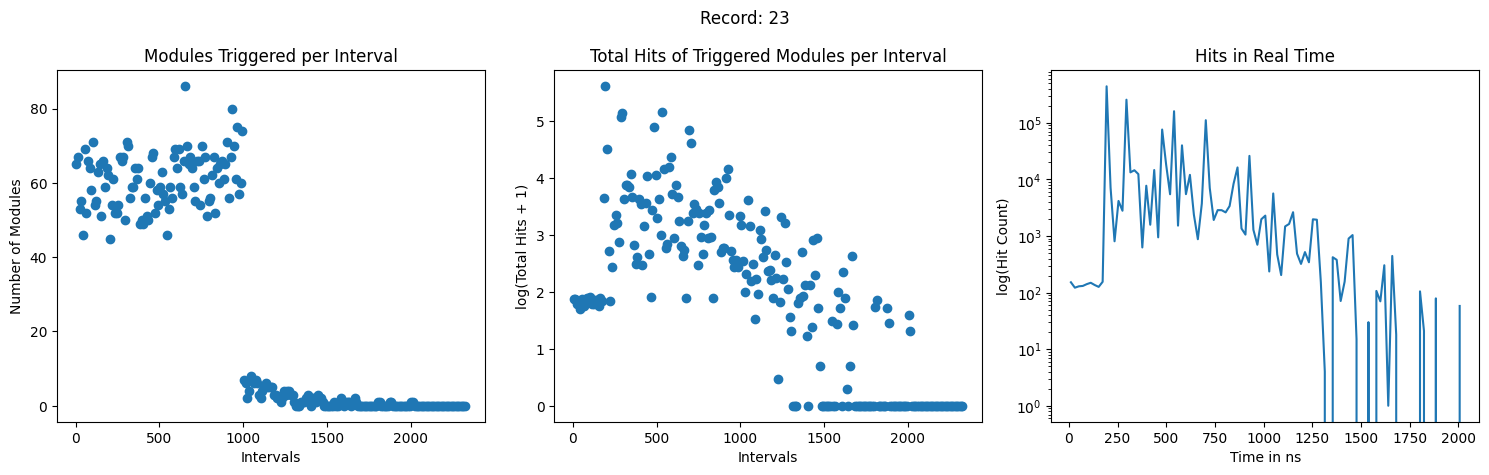

INFO:root:Plotting results for record: 24


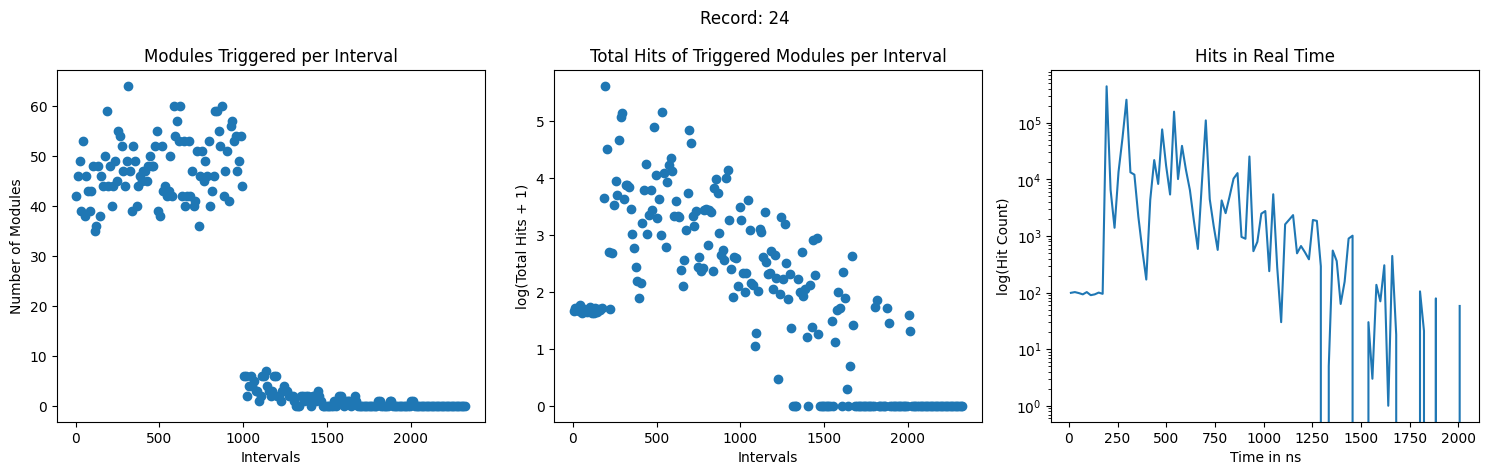

INFO:root:main ran in 24.548760890960693 s


In [9]:
_=ti.main(data_path=path,CL=0,plot=True)

0.19145727157592773
2


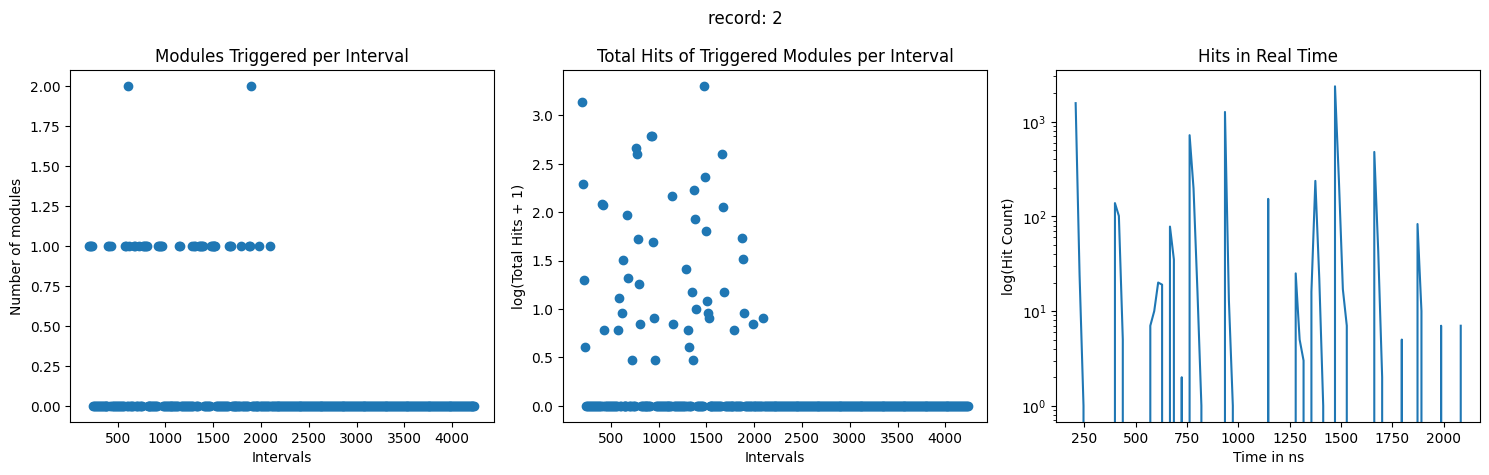

3


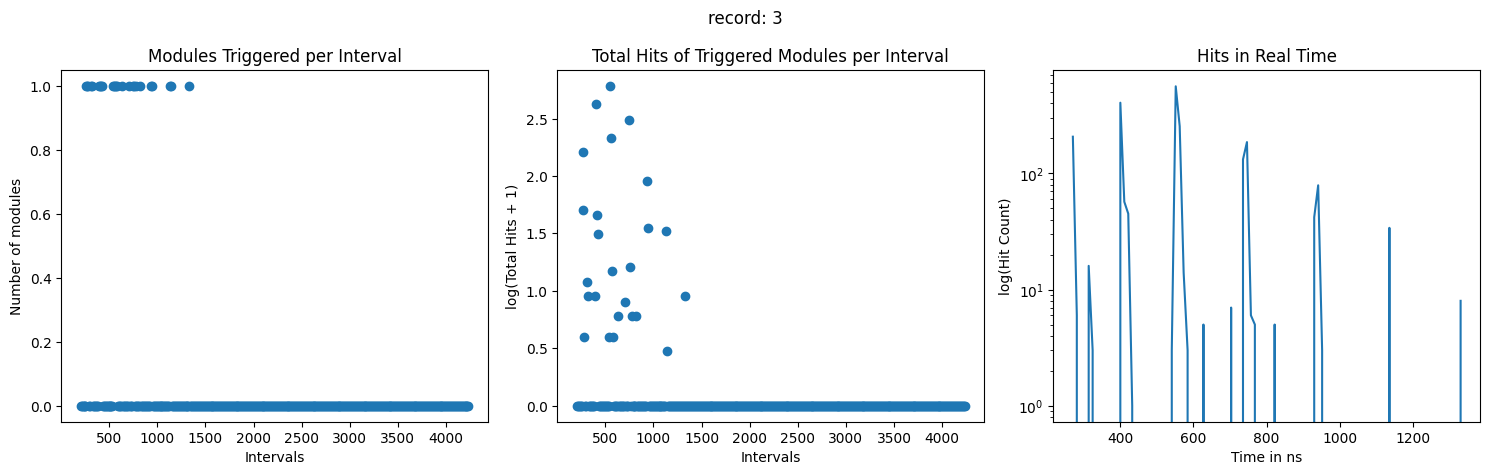

4


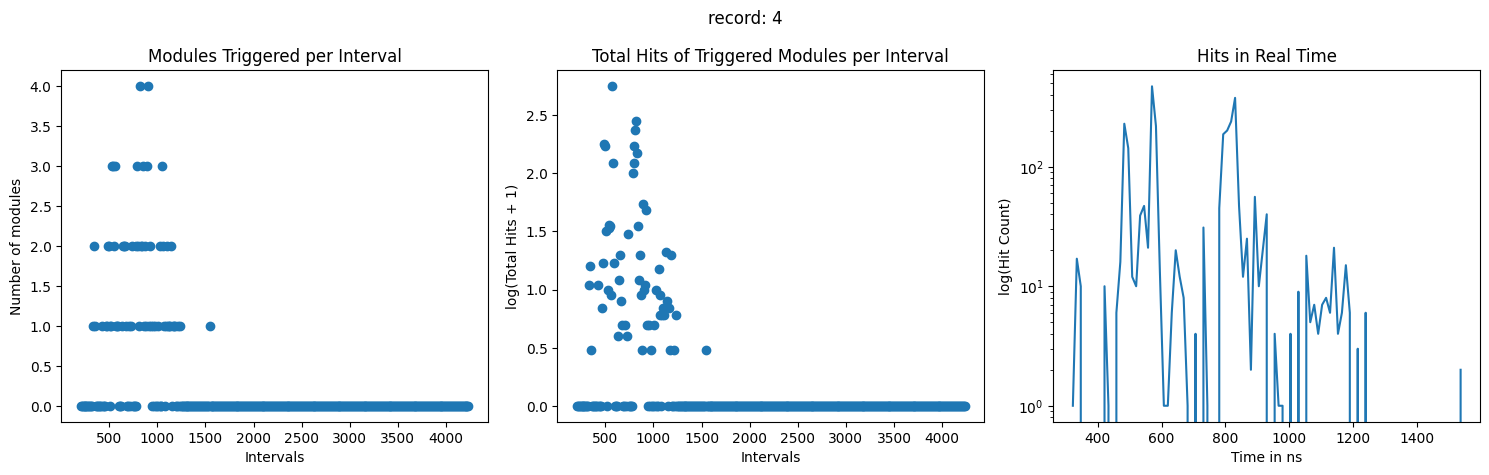

5


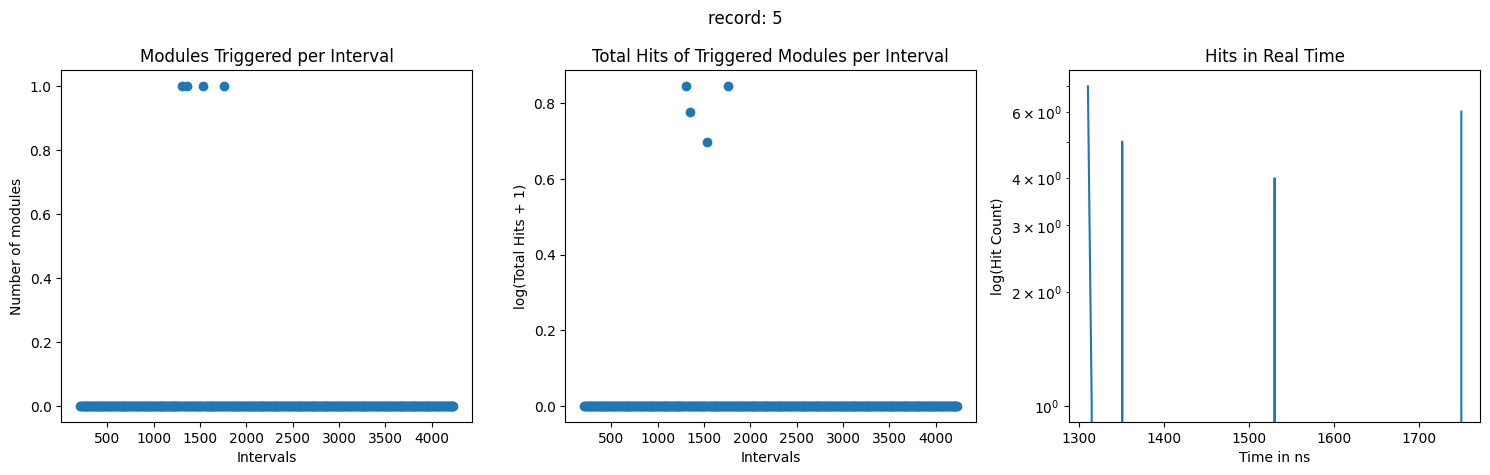

8


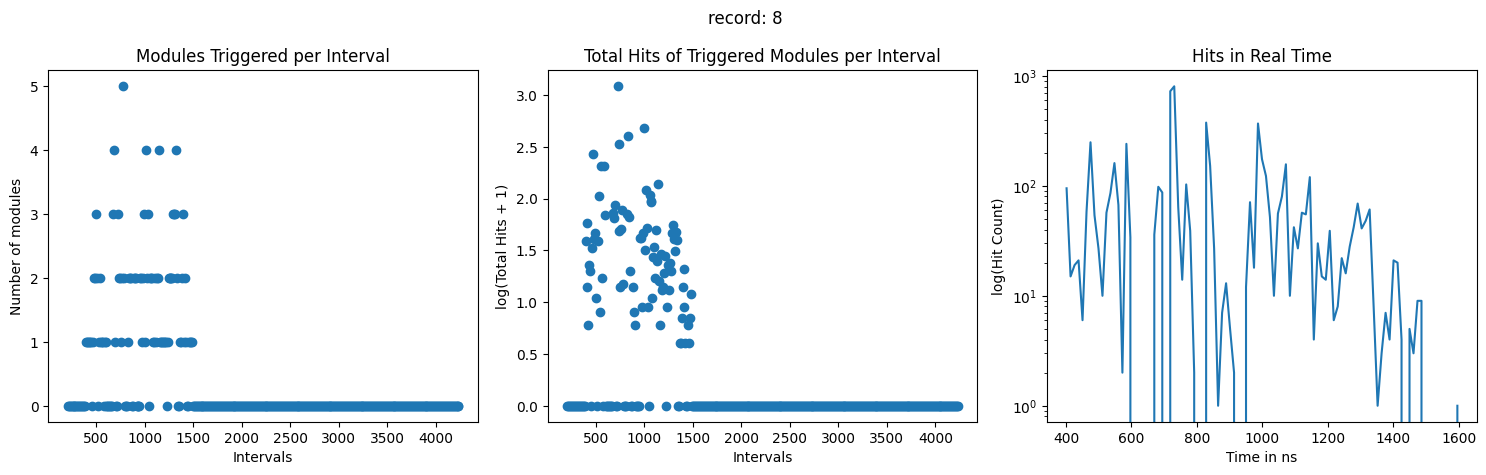

9


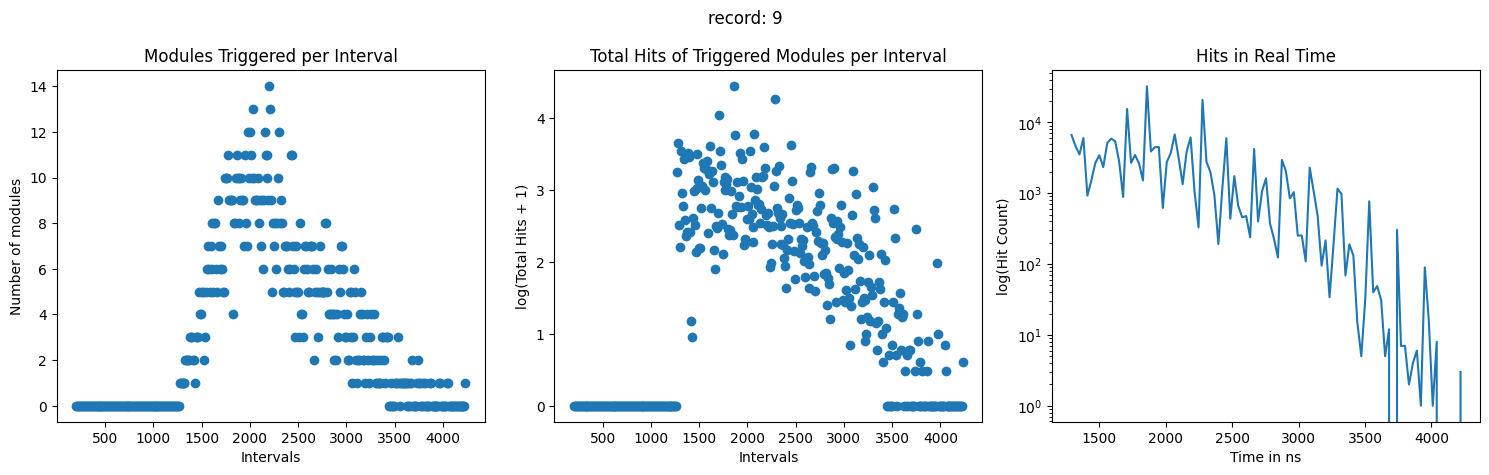

10


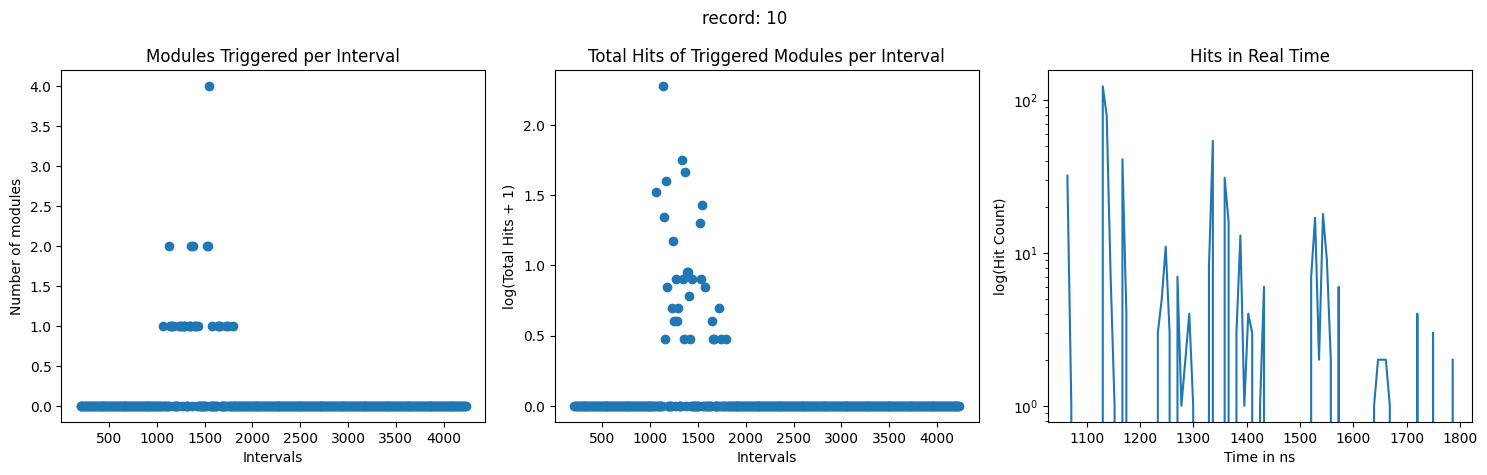

12


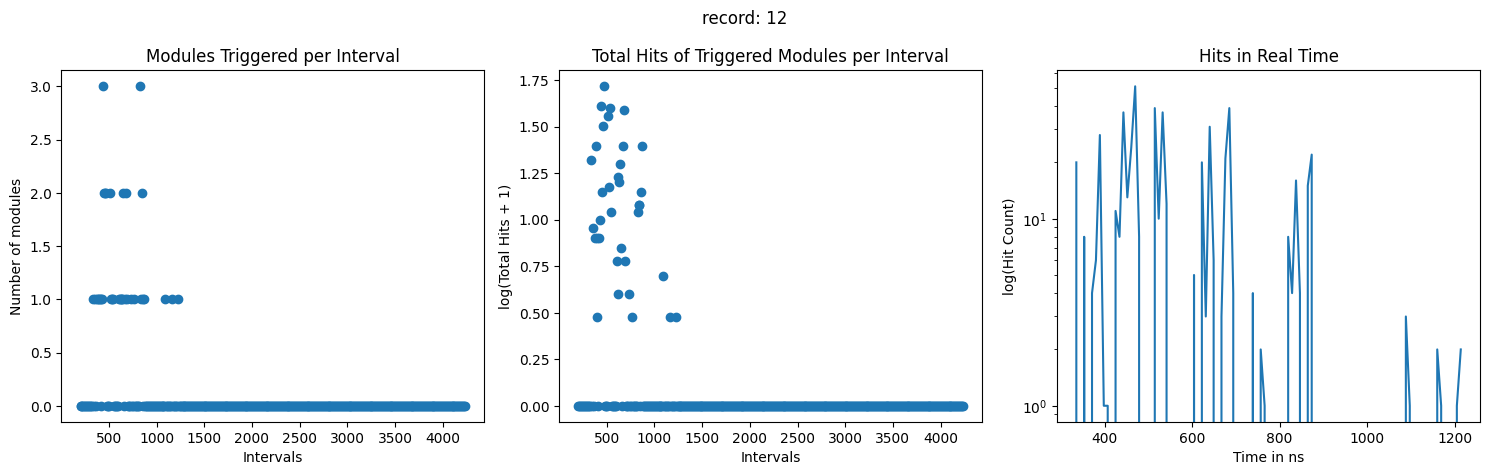

14


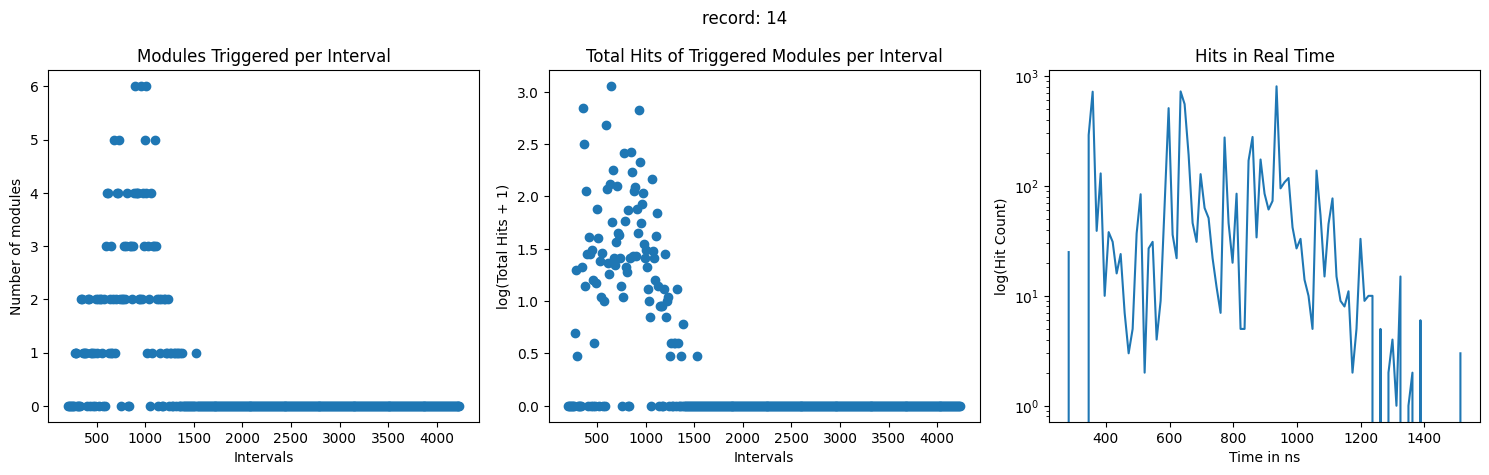

17


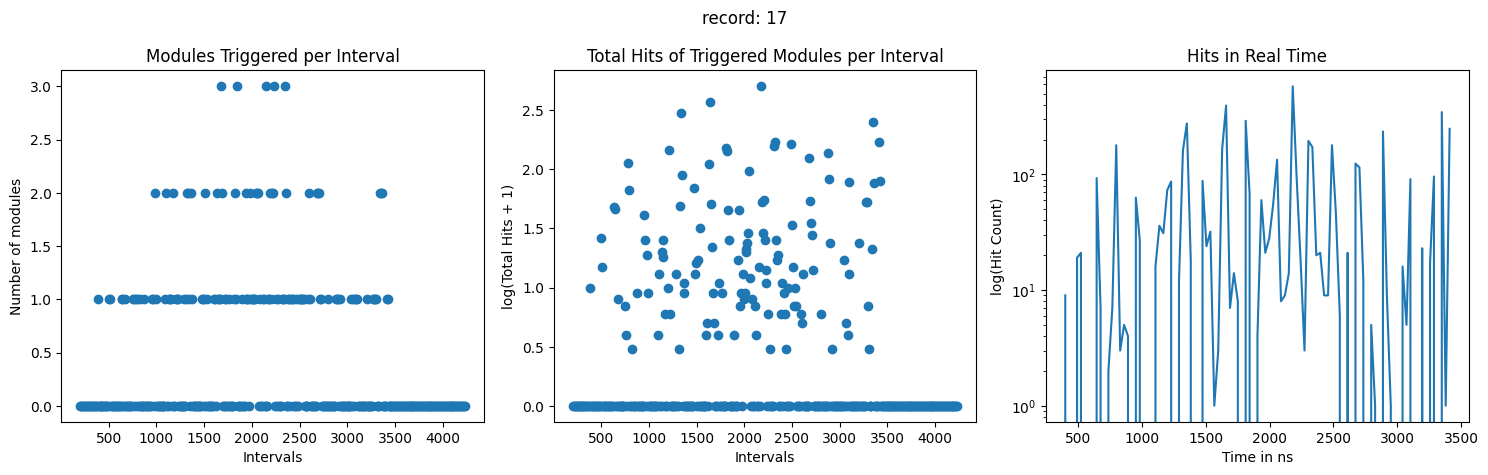

18


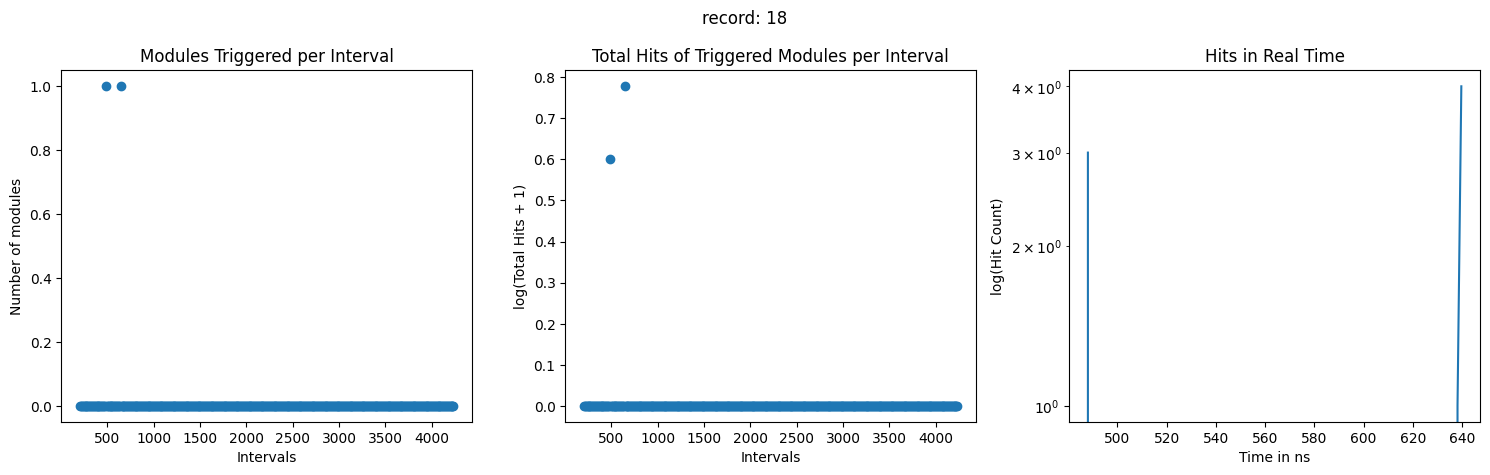

19


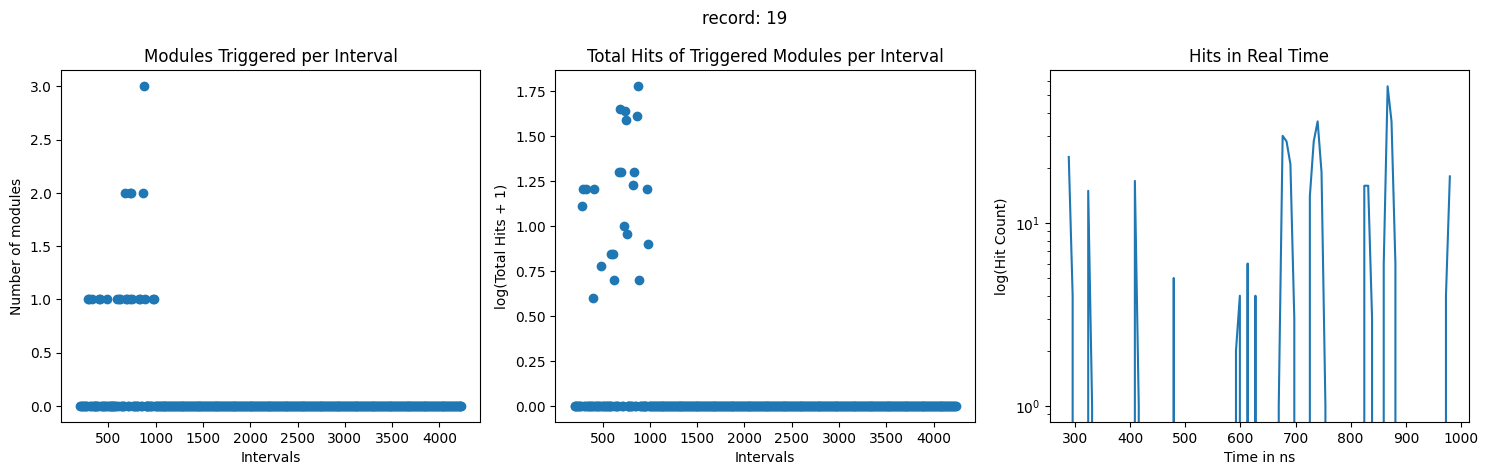

20


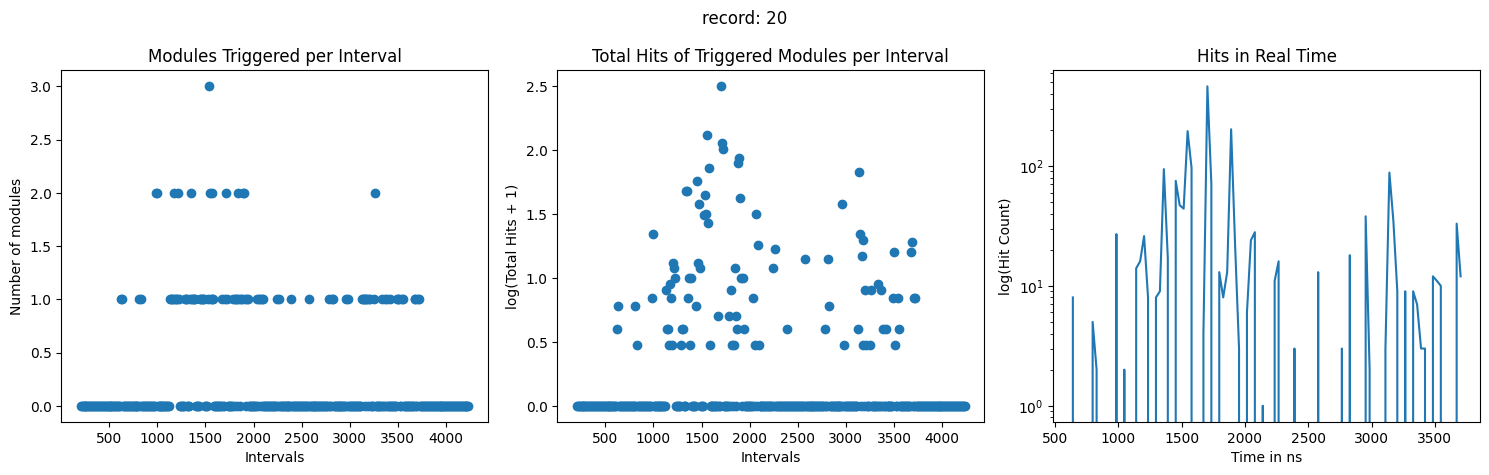

21


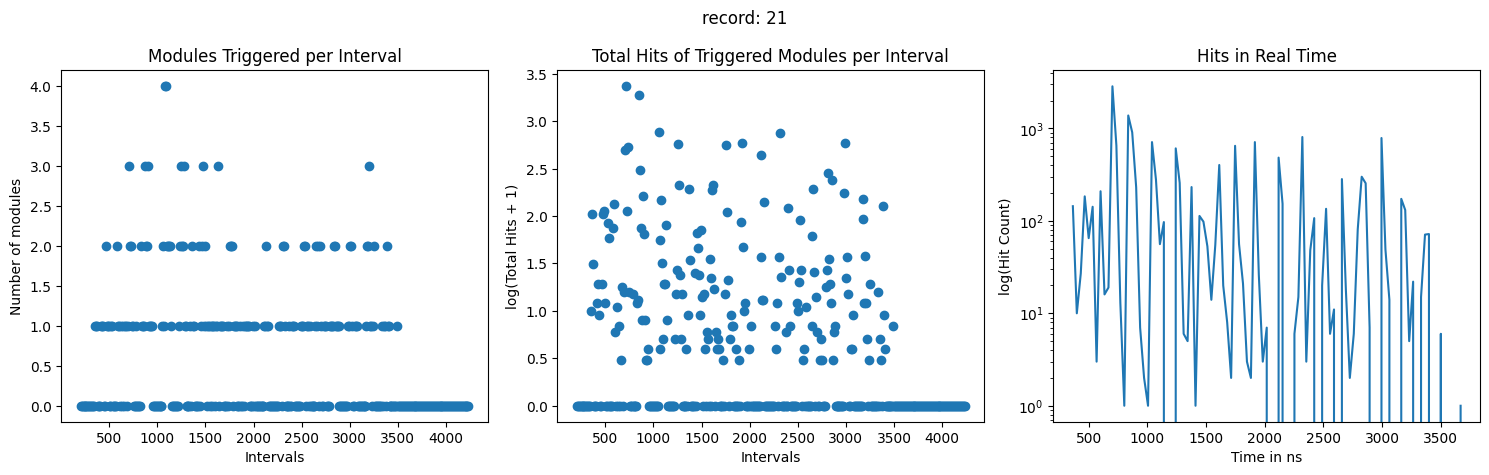

22


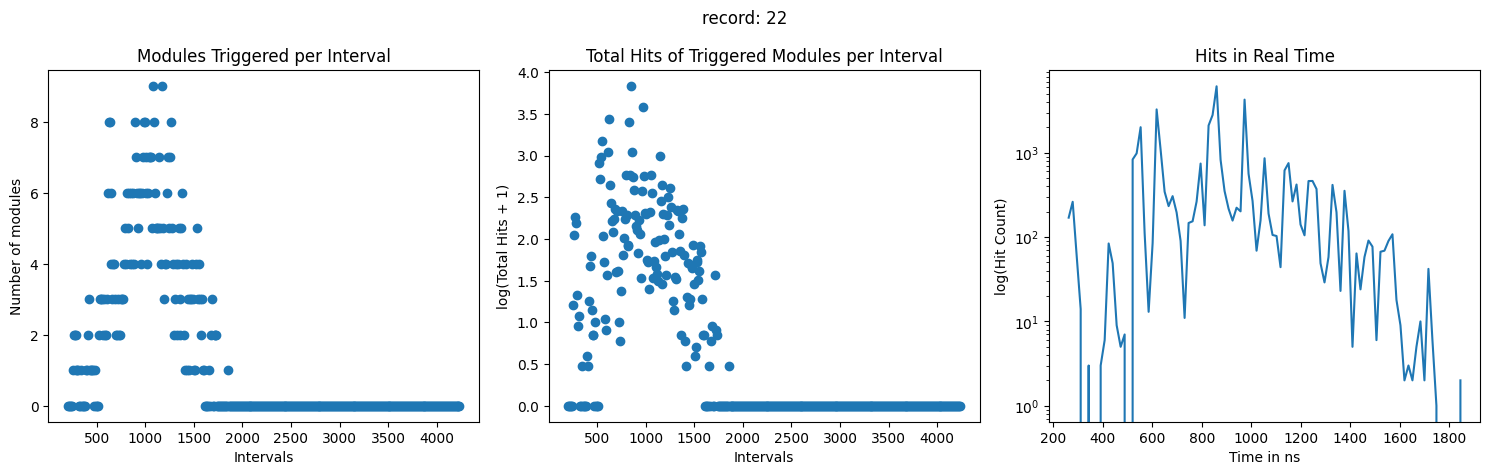

In [3]:
#loading took 81s
path='data/LargeTrack/0.h5'
collection = initialize_collection(path)
hits, records, timer, intervals = load_data(collection=collection, ignore_records=False)

hits.df

#59s
x = hits.df.groupby(['record_id', 'string_id', 'module_id', 'pmt_id'])['time'] \
        .apply(lambda times: np.sort(np.array(times))) \
        .reset_index()
x

t=time.time()
count_list = np.zeros((x.shape[0], len(timer) - 1)).astype(int)
pmt_activation=np.zeros((x.shape[0], len(timer) - 1)).astype(int)
for i in range(x.shape[0]):
    count_list[i] =np.histogram(x['time'][i],bins=timer)[0].astype(int)
    pmt_activation[i] = np.where(count_list[i] > 0, 1, 0)
print(time.time()-t)

x['counts'] = [count_list[i] for i in range(count_list.shape[0])]
x['pmt_activation']=[pmt_activation[i] for i in range(pmt_activation.shape[0])]

# Perform the grouping and aggregation without 'pmt_id'
#5s
x = (
    x.groupby(['record_id', 'string_id', 'module_id'])
    .agg({
        'time': concatenate_arrays,  # Concatenate time arrays
        'counts': sum_arrays,         # Sum the counts arrays
        'pmt_activation': sum_arrays   # Sum the pmt_activation arrays
    })
    .reset_index()
)


result=x[['record_id', 'string_id', 'module_id']].copy()
for i in range(16):
    result[f'Mod Count CL: {i}']=x['pmt_activation'].apply(lambda x: np.where(x > i, 1, 0))
    result[f'Mod Hit Count CL: {i}'] = result[f'Mod Count CL: {i}'] * x['counts']
    result[f'TS CL: {i}']=x[result[f'Mod Count CL: {i}'].apply(np.sum)>0]['time']
    result[f'TS CL: {i}']=result[f'TS CL: {i}'].apply(lambda f: np.where(np.isnan(f),np.array([0]),f))

dict_a = {col: sum_arrays for col in result.columns if col.startswith('Mod') or col.startswith('TS')}
dict_b = {col: concatenate_arrays for col in result.columns if col.startswith('TS')}
# Apply the aggregation function to all relevant columns
agg_dict={**dict_a,**dict_b}
plot_data = (
    result.groupby(['record_id'])
    .agg(agg_dict)  # Pass the dictionary to agg
    .reset_index()
)

plot_data

CL=1
for record in plot_data['record_id']:
    print(record)
    data=plot_data[plot_data['record_id']==record][[f'Mod Count CL: {CL}',f'Mod Hit Count CL: {CL}',f'TS CL: {CL}']]
    plt.figure().set_figwidth(15)

    plt.suptitle(f'record: {record}')

    plt.subplot(1, 3, 1)
    plt.scatter(intervals, data[f'Mod Count CL: {CL}'].iloc[0])
    plt.title('Modules Triggered per Interval')
    plt.ylabel('Number of modules')
    plt.xlabel('Intervals')


    plt.subplot(1, 3, 2)
    plt.scatter(intervals, np.log10(data[f'Mod Hit Count CL: {CL}'].iloc[0] + 1))
    plt.title('Total Hits of Triggered Modules per Interval')
    plt.ylabel('log(Total Hits + 1)')
    plt.xlabel('Intervals')
    

    plt.subplot(1, 3, 3)
    t=data[f'TS CL: {CL}'].iloc[0][data[f'TS CL: {CL}'].iloc[0]>0]
    t.sort()
    if t.size <= 1:
        plt.axhline(y=0)
        plt.show()
        continue
    bins = np.linspace(min(t), max(t), num=100)
    counts, _ = np.histogram(t, bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, counts)
    plt.xlabel('Time in ns')
    plt.ylabel('log(Hit Count)')
    plt.yscale('log')
    plt.title('Hits in Real Time')

    plt.tight_layout()
    plt.show()

In [10]:
path

'data/LargeTrack/0.h5'